# Sentiment Analysis using ML

Link to dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
import joblib
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

## Data preprocessing

Dataset already split into test, train and val. However, we want to try and do our own data splits. Therefore, merge the data together.

In [2]:
path = './archive/'
filenames = ['test.txt', 'train.txt', 'val.txt']

if not os.path.exists('all.csv'):
    # Combine all the files into one csv file
    with open('all.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=';')
        writer.writerow(['text', 'label'])

        for fname in filenames:
            with open(path + fname) as infile:
                for line in infile:
                    # Split the line into text and label using the semicolon
                    text, label = line.strip().split(';')
                    writer.writerow([text, label])

Read dataset

In [3]:
df = pd.read_csv('all.csv', delimiter=';')

Show statistics about the data

In [4]:
# Get summary statistics
print('Summary statistics:')
print(f'Total instances: {len(df)}')
print(f'Unique instances: {len(df.text.unique())}\n')
print(f'Categories: {df["label"].unique()}')
print('Instances of each category:')
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])} | {len(df[df["label"] == label])/len(df):.2%}')

Summary statistics:
Total instances: 20000
Unique instances: 19948

Categories: ['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']
Instances of each category:
sadness: 5797 | 28.98%
joy: 6761 | 33.80%
fear: 2373 | 11.87%
anger: 2709 | 13.54%
love: 1641 | 8.21%
surprise: 719 | 3.60%


Remove duplicate entries and show stats after

In [5]:
df = df.drop_duplicates(subset=['text'])

print('Summary statistics after removing duplicates:')
print(f'Total instances: {len(df)}')
print(f'Unique instances: {len(df.text.unique())}\n')
print(f'Categories: {df["label"].unique()}')
print('Instances of each category:')
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])}  | {len(df[df["label"] == label])/len(df):.2%}')

Summary statistics after removing duplicates:
Total instances: 19948
Unique instances: 19948

Categories: ['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']
Instances of each category:
sadness: 5794  | 29.05%
joy: 6743  | 33.80%
fear: 2366  | 11.86%
anger: 2704  | 13.56%
love: 1628  | 8.16%
surprise: 713  | 3.57%


Function to remove stop words and lemmatize

In [6]:
def process_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and len(token) > 1]
    return ' '.join(lemmas)

Remove stop words and lemmatize from data

In [7]:
if not os.path.exists('processed.csv'):
    # Split the text into tokens
    df['text'] = df['text'].apply(process_text)
    df.to_csv('processed.csv', index=False)
else:
    df = pd.read_csv('processed.csv')

Map labels to numerical

In [8]:
mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'love': 4,
    'surprise': 5
}

df['label'] = df['label'].apply(lambda x: mapping[x])

Show data statistics after data processing

In [9]:
print('Summary statistics:')
print(f'Total instances: {len(df)}')
print(f'Unique instances: {len(df.text.unique())}\n')
print(f'Categories: {df["label"].unique()}')
print('Instances of each category:')
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])}  | {len(df[df["label"] == label])/len(df):.2%}')

Summary statistics:
Total instances: 19948
Unique instances: 19487

Categories: [0 1 2 3 4 5]
Instances of each category:
0: 5794  | 29.05%
1: 6743  | 33.80%
2: 2366  | 11.86%
3: 2704  | 13.56%
4: 1628  | 8.16%
5: 713  | 3.57%


Split the data into train and test

In [10]:
num_of_classes = len(df['label'].unique())
# Split the data into training and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## Naive Bayes

Grid search using K-Fold

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('oversampler', RandomOverSampler(random_state=1)),
    ('clf', MultinomialNB())
])

param_grid = {
    'tfidf__max_features': [100, 1000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.01, 0.1, 1, 10],
    'tfidf__smooth_idf': (True, False),
    'tfidf__max_df': [0.25, 0.5, 0.75, 1.0],
    'tfidf__norm': ('l1', 'l2', None),
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='accuracy')
grid_search.fit(train_df['text'], train_df['label'])
result = grid_search.cv_results_

print(f'Best score: Accuracy: {grid_search.best_score_:.2%}, F1: {result["mean_test_f1"][grid_search.best_index_]:.2%}')
print(f'Best params: {grid_search.best_params_}')
with open('naive_bayes_best_parameters', 'w') as f:
    f.write(str(grid_search.best_params_))

Function to build model based on input

In [14]:
def build_model_nb(max_features, ngram_range, alpha, smooth_df, max_df, norm):
    vectorizer = TfidfVectorizer(max_features=max_features,
                                ngram_range=ngram_range,
                                smooth_idf=smooth_df,
                                max_df=max_df,
                                norm=norm)
    oversampler = RandomOverSampler(random_state=1)
    classifier = MultinomialNB(alpha=alpha)
    return Pipeline([('tfidf', vectorizer), ('oversampler', oversampler), ('clf', classifier)])

In [15]:
text_train, label_train = train_df['text'], train_df['label']

model_nb = build_model_nb(max_features=None,
                    ngram_range=(1, 2),
                    alpha=1.0,
                    smooth_df=True,
                    max_df=1.0,
                    norm='l1')

# Create the model and train on entire training data
model_nb.fit(text_train, label_train)
joblib.dump(model_nb, 'naive_bayes.pkl')

print('Classification report:')
print(classification_report(test_df['label'], model_nb.predict(test_df['text']), zero_division=0))


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1186
           1       0.96      0.81      0.88      1365
           2       0.80      0.84      0.82       457
           3       0.85      0.91      0.88       507
           4       0.66      0.91      0.76       330
           5       0.52      0.91      0.66       145

    accuracy                           0.86      3990
   macro avg       0.79      0.88      0.82      3990
weighted avg       0.88      0.86      0.86      3990



Get Naive Bayes model parameters

In [261]:
naive_bayes = model_nb.named_steps['clf']
class_prior = naive_bayes.class_log_prior_
feature_log_prob = naive_bayes.feature_log_prob_

print('Naive Bayes model parameters:')
print(f'Class prior: {class_prior}')
print(f'Feature log probability shape: {feature_log_prob.shape}')

Naive Bayes model parameters:
Class prior: [-1.79175947 -1.79175947 -1.79175947 -1.79175947 -1.79175947 -1.79175947]
Feature log probability shape: (6, 89049)


Function to predict using Naive Bayes

In [324]:
def naive_bayes(text):
    emotions = ['sadness', 'joy', 'fear', 'anger', 'love', 'surprise']
    # Load the model
    model = joblib.load('naive_bayes.pkl')
    processed_text = process_text(text)
    prediction = model.predict([processed_text])
    return emotions[prediction[0]]

print(naive_bayes('Today is a good day for cakes'))

joy


## Logistic Regression Model

Grid search using K-Fold

In [129]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('oversampler', RandomOverSampler(random_state=1)),
    ('clf', LogisticRegression())
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__smooth_idf': (True, False),
    'tfidf__max_df': [0.25, 0.5, 1.0],
    'tfidf__norm': ['l1', 'l2'],
    'clf__solver': ['newton-cg', 'sag', 'saga'],
    'clf__C': [0.1, 1, 10],
    'clf__multi_class': ['ovr', 'multinomial'],
    'clf__tol': [0.01, 0.1, 1],
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='accuracy')
grid_search.fit(train_df['text'], train_df['label'])
result = grid_search.cv_results_

print(f'Best score: Accuracy: {grid_search.best_score_:.2%}, F1: {result["mean_test_f1"][grid_search.best_index_]:.2%}')
print(f'Best params: {grid_search.best_params_}')
with open('naive_bayes_best_parameters', 'w') as f:
    f.write(str(grid_search.best_params_))


Best score: Accuracy: 89.19%, F1: 89.26%
Best params: {'clf__C': 10, 'clf__multi_class': 'ovr', 'clf__solver': 'sag', 'clf__tol': 0.1, 'tfidf__max_df': 1.0, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True}


Function to build model based on input

In [11]:
def build_model_lr(solver, C, multi_class, tol, max_df, norm):
    vectorizer = TfidfVectorizer(max_features=None,
                                ngram_range=(1, 2),
                                smooth_idf=True,
                                max_df=max_df,
                                norm=norm,)
    oversampler = RandomOverSampler(random_state=1)
    classifier = LogisticRegression(solver=solver,
                                    C=C,
                                    multi_class=multi_class,
                                    tol=tol,
                                    max_iter=500)
    return Pipeline([('tfidf', vectorizer), ('oversampler', oversampler), ('clf', classifier)])

In [12]:
text_train, label_train = train_df['text'], train_df['label']

model_lr = build_model_lr(solver='sag',
                        C=1,
                        multi_class='ovr',
                        tol=0.1,
                        max_df=1.0,
                        norm='l2')
                        
# Create the model and train on entire training data
model_lr.fit(text_train, label_train)
joblib.dump(model_lr, 'logistic_regression.pkl')
print(classification_report(test_df['label'], model_lr.predict(test_df['text']), zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1186
           1       0.93      0.88      0.91      1365
           2       0.88      0.83      0.85       457
           3       0.88      0.91      0.89       507
           4       0.74      0.91      0.82       330
           5       0.70      0.88      0.78       145

    accuracy                           0.89      3990
   macro avg       0.85      0.89      0.86      3990
weighted avg       0.90      0.89      0.89      3990



Get logistic regression model parameters

In [262]:
logistic_regression = model_lr.named_steps['clf']
coef = logistic_regression.coef_
intercept = logistic_regression.intercept_
n_iter = logistic_regression.n_iter_

print(f'Model parameters:')
print(f'Coefficient: {coef}')
print(f'Coefficient shape: {coef.shape}')
print(f'Intercept: {intercept}')
print(f'Number of iterations: {n_iter}')

Model parameters:
Coefficient: [[ 0.13366129  0.13366129 -0.0351478  ... -0.03159558  0.19915531
   0.19915531]
 [-0.03947745 -0.03947745  0.07327729 ...  0.06840042 -0.08544618
  -0.08544618]
 [-0.03282278 -0.03282278 -0.01739925 ... -0.01130319 -0.01650352
  -0.01650352]
 [-0.02969704 -0.02969704  0.         ... -0.01423157 -0.04548215
  -0.04548215]
 [-0.01316996 -0.01316996 -0.01724062 ... -0.01328473 -0.02758726
  -0.02758726]
 [-0.00747436 -0.00747436 -0.007052   ... -0.00854177 -0.0124986
  -0.0124986 ]]
Coefficient shape: (6, 89049)
Intercept: [-1.73791154 -1.26319375 -2.0857877  -1.88193389 -2.3996245  -3.1324066 ]
Number of iterations: [4 5 4 3 3 3]


Function to run the model on a given piece of text

In [388]:
def logistic_regression(text):
    emotions = ['sadness', 'joy', 'fear', 'anger', 'love', 'surprise']
    # Load the model
    model = joblib.load('naive_bayes.pkl')
    processed_text = process_text(text)
    prediction = model.predict([processed_text])
    return emotions[prediction[0]]

logistic_regression("Today is a good day for cakes")

'joy'

## Graphing

Function to calculate scores

In [2]:
def calculate_score_learning(model, text_train, label_train):
    train_size, train_score, test_score = learning_curve(model, text_train, label_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    train_score_mean = np.mean(train_score, axis=1)
    train_score_std = np.std(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    test_score_std = np.std(test_score, axis=1)
    return train_size, train_score_mean, train_score_std, test_score_mean, test_score_std

Plot learning curve for Naive Bayes

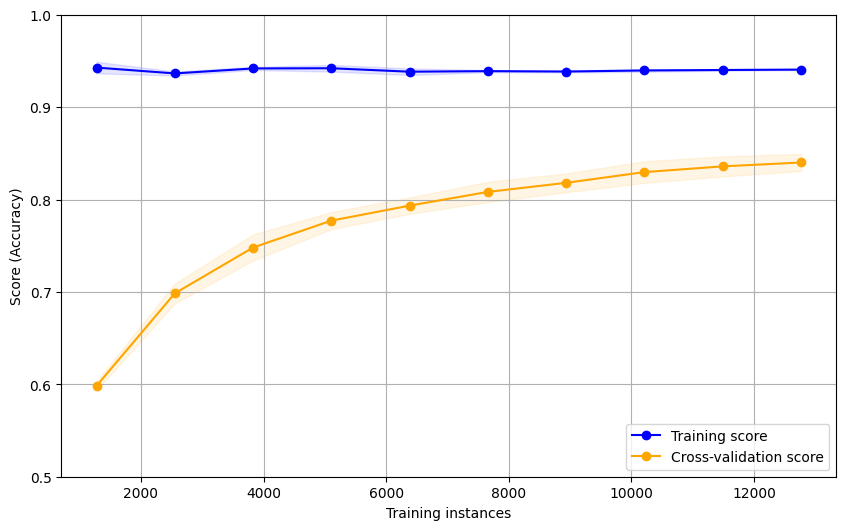

In [19]:
nb_scores = calculate_score_learning(model_nb, text_train, label_train)

plt.figure(figsize=(10, 6))
# Naive Bayes
plt.fill_between(nb_scores[0], nb_scores[1] - nb_scores[2], nb_scores[1] + nb_scores[2], alpha=0.1, color='blue')
plt.fill_between(nb_scores[0], nb_scores[3] - nb_scores[4], nb_scores[3] + nb_scores[4], alpha=0.1, color="orange")
plt.plot(nb_scores[0], nb_scores[1], 'o-', color="blue", label="Training score")
plt.plot(nb_scores[0], nb_scores[3], 'o-', color="orange", label="Cross-validation score")
plt.ylim([0.5, 1.0])
plt.xlabel("Training instances")
plt.ylabel("Score (Accuracy)")
plt.legend(loc="lower right")
plt.grid()
plt.savefig('learning_curve_nb.png')
plt.show()

Plot learning curve for Logistic Regression

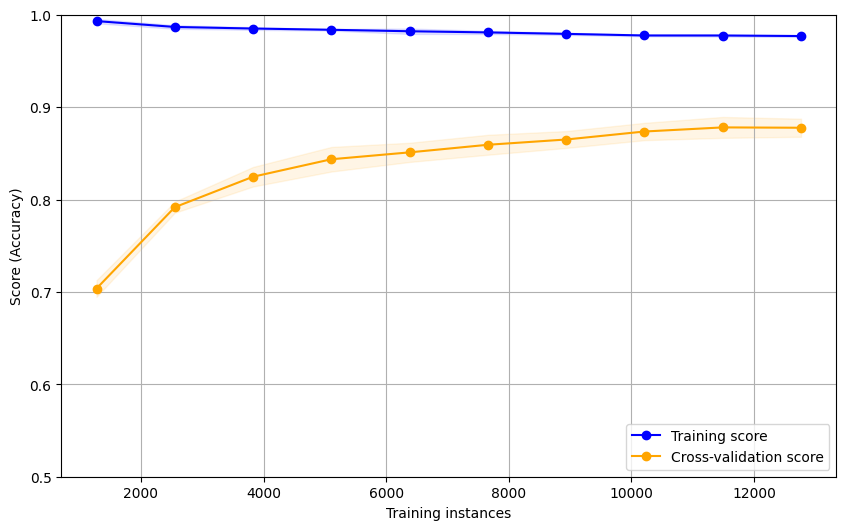

In [20]:
lr_scores = calculate_score_learning(model_lr, text_train, label_train)

plt.figure(figsize=(10, 6))
# Logistic Regression
plt.fill_between(lr_scores[0], lr_scores[1] - lr_scores[2], lr_scores[1] + lr_scores[2], alpha=0.1, color='blue')
plt.fill_between(lr_scores[0], lr_scores[3] - lr_scores[4], lr_scores[3] + lr_scores[4], alpha=0.1, color="orange")
plt.plot(lr_scores[0], lr_scores[1], 'o-', color="blue", label="Training score")
plt.plot(lr_scores[0], lr_scores[3], 'o-', color="orange", label="Cross-validation score")
plt.ylim([0.5, 1.0])
plt.xlabel("Training instances")
plt.ylabel("Score (Accuracy)")
plt.grid()
plt.legend(loc="lower right")
plt.savefig('learning_curve_lr.png')
plt.show()

Plot ROC Curve of Naive Bayes

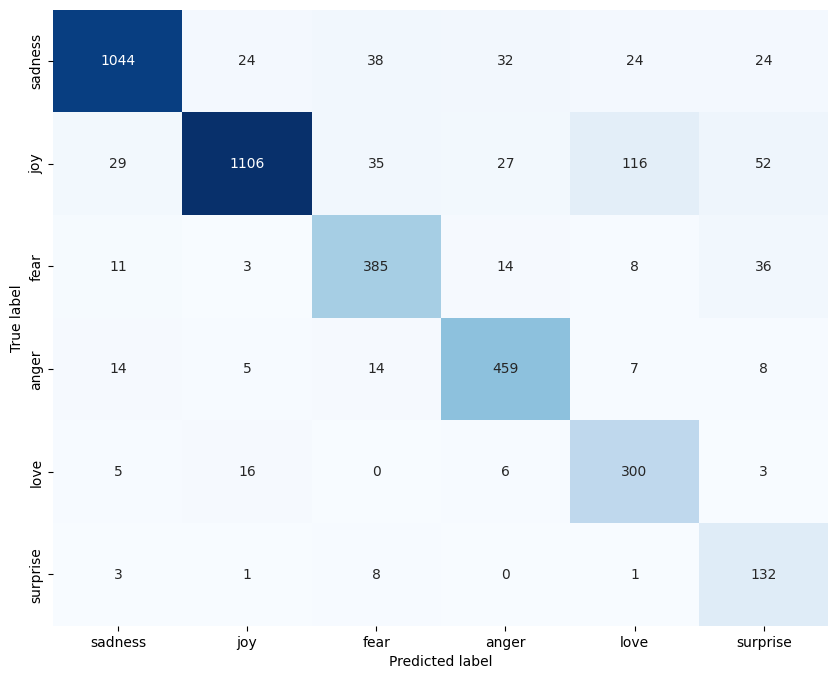

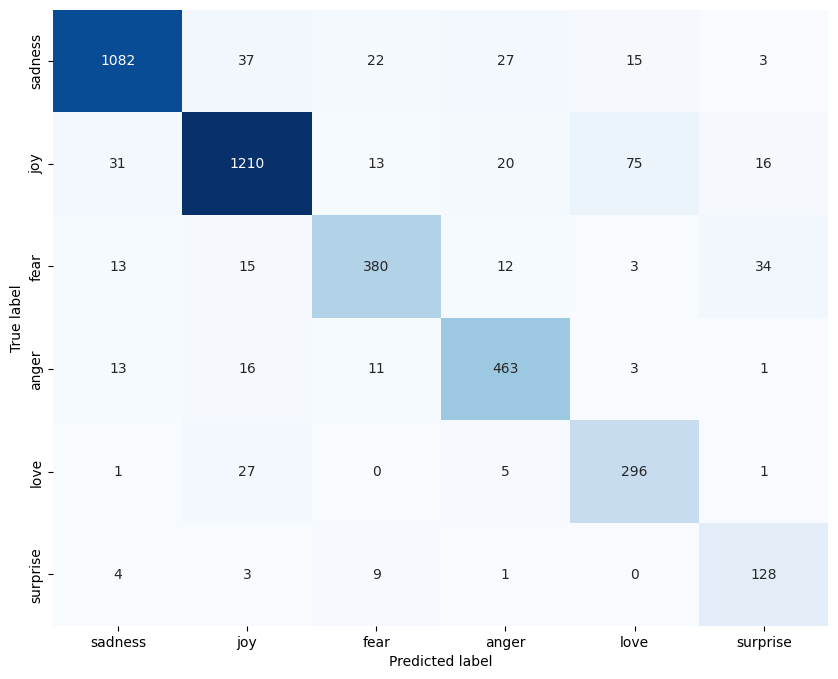

In [403]:
y_prob_nb = model_nb.predict(test_df['text'])
y_probs_lr = model_lr.predict(test_df['text'])
cm_nb = confusion_matrix(test_df['label'], y_prob_nb)
cm_lr = confusion_matrix(test_df['label'], y_probs_lr)

mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'fear',
    3: 'anger',
    4: 'love',
    5: 'surprise'
}

emotion_labels = [mapping[i] for i in range(len(mapping))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_matrix_nb.png')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_matrix_lr.png')

Function to calculate all metrics

In [331]:
def calculate_score_metrics(model, text_test, label_test):
    y_pred = model.predict(text_test)
    accuracy = accuracy_score(label_test, y_pred)
    f1 = f1_score(label_test, y_pred, average='weighted')
    precision = precision_score(label_test, y_pred, average='weighted')
    recall = recall_score(label_test, y_pred, average='weighted')
    return accuracy, f1, precision, recall

Plot bar chart comparing model

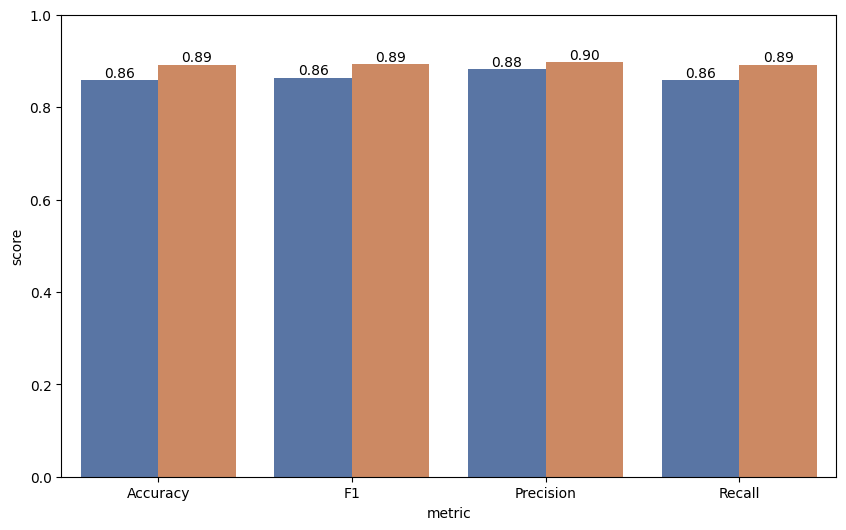

In [400]:
nb_metrics = calculate_score_metrics(model_nb, test_df['text'], test_df['label'])
lr_metrics = calculate_score_metrics(model_lr, test_df['text'], test_df['label'])

# Turn the metrics into a dataframe with metric, score and model columns
nb_metrics = calculate_score_metrics(model_nb, test_df['text'], test_df['label'])
lr_metrics = calculate_score_metrics(model_lr, test_df['text'], test_df['label'])

# Turn the metrics into a dataframe with metric, score and model columns
metrics_df = pd.concat([
    pd.DataFrame({'metric': ['Accuracy', 'F1', 'Precision', 'Recall'],
                  'score': nb_metrics,
                  'model': 'Naive Bayes'}),
    pd.DataFrame({'metric': ['Accuracy', 'F1', 'Precision', 'Recall'],
                  'score': lr_metrics,
                  'model': 'Logistic Regression'})
], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.set_style()
plot = sns.barplot(x='metric', y='score', hue='model', data=metrics_df, palette='deep')
plot.bar_label(plot.containers[0], fmt='%.2f')
plot.bar_label(plot.containers[1], fmt='%.2f')
plot.set_ylim([0, 1])
# Hide legend
plot.legend().set_visible(False)
